In [2]:
# Step 1: Import Necessary Libraries
import warnings
warnings.filterwarnings("ignore")
import os
import json
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
# Enable GPU
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# -------------------------------------------------------------------------------------------------------------------------------

# Step 2: Define Paths & Parameters
DATASET_PATH = "../../../dataset"
PROCESSED_DATA_PATH = "cnn_processed_data"
SAVED_MODEL_PATH = "cnn_models"
CATEGORIES = ["with_mask", "without_mask"]

# Image Processing Parameters
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 10

# Ensure necessary directories exist
os.makedirs(PROCESSED_DATA_PATH, exist_ok=True)
os.makedirs(SAVED_MODEL_PATH, exist_ok=True)

# -------------------------------------------------------------------------------------------------------------------------------

GPU Available: []


In [4]:
# Step 3: Load or Process Dataset
def load_or_process_dataset():
    """Load preprocessed dataset if available, else raise error (no raw image processing)."""
    X_path = os.path.join(PROCESSED_DATA_PATH, "X.npy")
    y_path = os.path.join(PROCESSED_DATA_PATH, "y.npy")

    if os.path.exists(X_path) and os.path.exists(y_path):
        print("Loading preprocessed dataset...")
        X = np.load(X_path)
        y = np.load(y_path)
        return X, y
    else:
        raise FileNotFoundError("Preprocessed dataset not found. Ensure X.npy and y.npy exist in cnn_processed_data.")

X, y = load_or_process_dataset()

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# -------------------------------------------------------------------------------------------------------------------------------

Loading preprocessed dataset...


In [5]:
# Step 4: Define CNN Model
def create_model(activation="relu", optimizer="adam"):
    """Creates and returns a CNN model."""
    model = keras.Sequential([
        layers.Conv2D(32, (3, 3), activation=activation, input_shape=(128, 128, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation=activation),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation=activation),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation=activation),
        layers.Dense(1, activation="sigmoid")  # Binary classification
    ])
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
    return model

# -------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# Step 5: Train and Save Multiple Models
configs = [
    {"activation": "relu", "optimizer": "adam"},
    {"activation": "tanh", "optimizer": "adam"},
    {"activation": "relu", "optimizer": "sgd"},
]

for config in configs:
    model_filename = f"model_{config['activation']}_{config['optimizer']}.keras"
    model_path = os.path.join(SAVED_MODEL_PATH, model_filename)
    history_filename = f"history_{config['activation']}_{config['optimizer']}.json"
    history_path = os.path.join(SAVED_MODEL_PATH, history_filename)

    if os.path.exists(model_path) and os.path.exists(history_path):
        print(f"Skipping training for {model_filename} as it already exists.")
        continue

    print(f"\nTraining model: {model_filename}...")
    with tf.device('/GPU:0'):
        model = create_model(activation=config["activation"], optimizer=config["optimizer"])
        history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=EPOCHS, batch_size=BATCH_SIZE)

    # Save model in the recommended format
    model.save(model_path)

    # Save training history
    with open(history_path, "w") as f:
        json.dump(history.history, f)

# -------------------------------------------------------------------------------------------------------------------------------


Training model: model_relu_adam.keras...
Epoch 1/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 64s 586ms/step - accuracy: 0.7402 - loss: 0.5184 - val_accuracy: 0.8950 - val_loss: 0.2680
Epoch 2/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 58s 566ms/step - accuracy: 0.9160 - loss: 0.2072 - val_accuracy: 0.9255 - val_loss: 0.2078
Epoch 3/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 51s 492ms/step - accuracy: 0.9263 - loss: 0.1973 - val_accuracy: 0.9426 - val_loss: 0.1582
Epoch 4/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 45s 434ms/step - accuracy: 0.9482 - loss: 0.1319 - val_accuracy: 0.9621 - val_loss: 0.1155
Epoch 5/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 46s 444ms/step - accuracy: 0.9614 - loss: 0.1092 - val_accuracy: 0.9328 - val_loss: 0.1772
Epoch 6/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 48s 471ms/step - accuracy: 0.9732 - loss: 0.0785 - val_accuracy: 0.9560 - val_loss: 0.1020
Epoch 7/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 49s 474ms/step - accuracy: 0.9734 - loss: 0.0642 - val_accuracy: 0.9695 - val_loss: 0.0985
Epoch 8/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 4

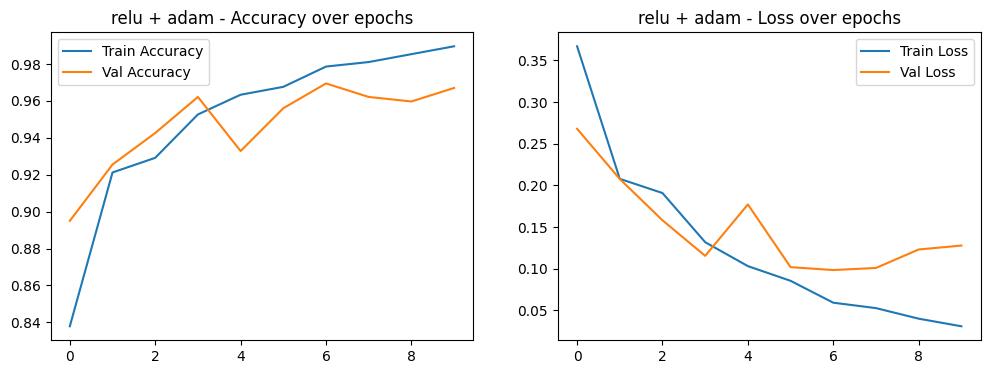

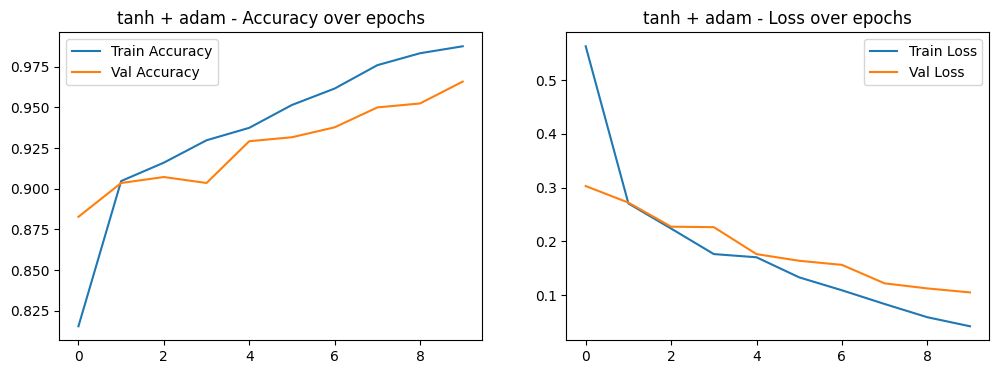

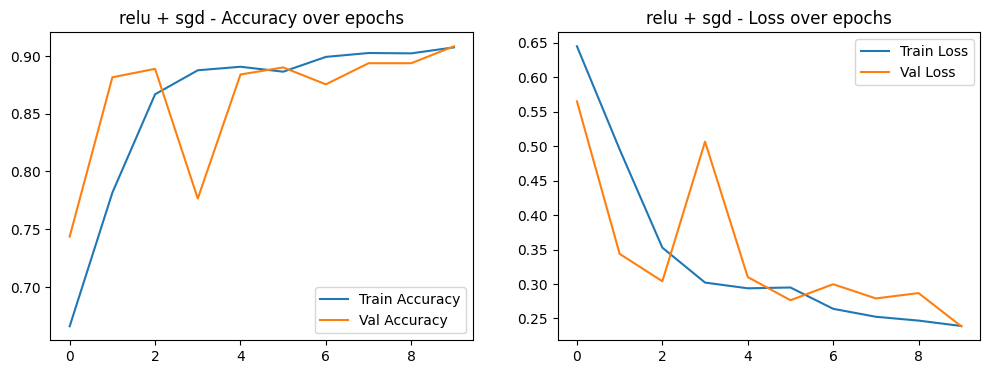

In [7]:
# Step 6: Plot Training Results
def plot_history(history_data, title):
    """Plots accuracy and loss over epochs."""
    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history_data["accuracy"], label="Train Accuracy")
    plt.plot(history_data["val_accuracy"], label="Val Accuracy")
    plt.legend()
    plt.title(f"{title} - Accuracy over epochs")

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history_data["loss"], label="Train Loss")
    plt.plot(history_data["val_loss"], label="Val Loss")
    plt.legend()
    plt.title(f"{title} - Loss over epochs")

    plt.show()

# Load and plot all training histories
for config in configs:
    history_path = os.path.join(SAVED_MODEL_PATH, f"history_{config['activation']}_{config['optimizer']}.json")

    with open(history_path, "r") as f:
        history_data = json.load(f)

    plot_history(history_data, f"{config['activation']} + {config['optimizer']}")

# -------------------------------------------------------------------------------------------------------------------------------

In [8]:
# Step 7: Evaluate Models
for config in configs:
    model_path = os.path.join(SAVED_MODEL_PATH, f"model_{config['activation']}_{config['optimizer']}.keras")
    model = keras.models.load_model(model_path)  # Load model in new format
    val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
    print(f"{config['activation']} + {config['optimizer']} - Validation Accuracy: {val_acc:.4f}")

print("\nAll models and training histories saved in:", SAVED_MODEL_PATH)

# -------------------------------------------------------------------------------------------------------------------------------

relu + adam - Validation Accuracy: 0.9670
tanh + adam - Validation Accuracy: 0.9658
relu + sgd - Validation Accuracy: 0.9084

All models and training histories saved in: cnn_models
